In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import random
import os
import math
from timeit import default_timer as timer
from tqdm import tqdm, trange, tqdm_notebook

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


In [2]:
def plot_curves(title, data, y_title, x_title='Epoch', legend=[], x_labels_offset = 0):
    fig = plt.figure(figsize=(8, 4))
        
    for row in data:
        x = range(x_labels_offset, len(row))
        plt.plot(x, row[x_labels_offset:])
    
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.grid(True)
    plt.legend(legend, loc='upper left')
    plt.show()

In [80]:
def predicted_to_df_and_to_file(predicted, filename):    
    ids = []
    values = []
    
    for idx, val in enumerate(predicted):
        ids.append(idx + 1)
        values.append(val[0])
    
    df = pd.DataFrame({'id': ids, 'label': values})
    df['label'] = df['label'].clip(lower=0.01, upper=0.99)
    
    df.to_csv(f"{filename}_submission.csv", index=False, float_format='%.3f')
    
    return df

In [41]:
prepared_path = './data/prepared'

In [42]:
WIDTH = 180
HEIGHT = 180
IMG_SIZE = (WIDTH, HEIGHT)
CHANNELS = 3

In [43]:
test_data_path = './data/test'
test_files = os.listdir(test_data_path)
test_data = []
for test_file in test_files:
    full_path = f'{test_data_path}/{test_file}'
    img_data = img_to_array(load_img(full_path, target_size=IMG_SIZE))
    test_data.append(img_data)

test_data = np.array(test_data) / 255
#test_data = test_data[: 1000]
test_data.shape

(12500, 180, 180, 3)

In [44]:
class BaseModel():
    def __init__(self):
        self.init_basic_params()
        
        self.compile()
        
        self.tf_writer.add_graph(self.session.graph)
    
    def rand_str(self, str_len=20):
        return ''.join(random.choices(string.ascii_uppercase + string.digits, k=str_len))
    
    def init_basic_params(self):
        tf.reset_default_graph()
        self.logs_path = './tf_board/' + self.__class__.__name__
        self.var_scope = self.rand_str()
        self.print_separator = '-' * 65
        self.session = None
        self.dropout_rate_tf = tf.placeholder(tf.float32)
        self.dropout_rate_tf_cnn = tf.placeholder(tf.float32)
        
        self.input_size = [WIDTH, HEIGHT, CHANNELS]
        self.output_size = 1
        
        self.dropout_rate = 0.15
        self.dropout_rate_cnn = 0.15
        
        self.start_learning_rate = 0.01
        
        self.tf_writer = tf.summary.FileWriter(self.logs_path)
    
    def __del__(self): 
        print('object del')
        if self.session:
            tf.reset_default_graph()
            self.session.close()
    
    def reset_internal_params(self):
        self.hidden_layers = {}
        self.hidden_layers_W = {}
        self.hidden_layers_b = {}
        self.history = {
            'acc_train': [],
            'acc_valid': [],
            'loss_train': [],
            'loss_valid': []
        }
        
        self.global_step = tf.Variable(0, trainable=False)
        self.decay_steps = tf.Variable(100000, trainable=False)
    
    def get_W(self, layer_id, shape):
        #with tf.variable_scope(self.var_scope, reuse=tf.AUTO_REUSE):
        #W = tf.Variable(tf.truncated_normal(shape, stddev=0.1, mean=0), name=f'W_{layer_id}')
        initializer = tf.contrib.layers.variance_scaling_initializer()
        W = tf.Variable(initializer(shape), name=f'W_{layer_id}')
        self.hidden_layers_W[layer_id] = W

        return self.hidden_layers_W[layer_id]

    def get_b(self, layer_id, shape):
        #with tf.variable_scope(self.var_scope, reuse=tf.AUTO_REUSE):
        self.hidden_layers_b[layer_id] = tf.Variable(tf.zeros(shape), name=f'b_{layer_id}')
        
        return self.hidden_layers_b[layer_id]
        
    def get_dense_layer(self, layer_id, prev_layer, units_count, activ=tf.nn.relu):
        input_size = prev_layer.get_shape().as_list()[1]
        
        W = self.get_W(layer_id, [input_size, units_count])
        b = self.get_b(layer_id, [units_count])
        
        layer = tf.matmul(prev_layer, W) + b
        
        if activ:
            layer = activ(layer, name=f'Lay_Dense_{layer_id}')
        
        return layer
    
    def get_conv2_layer(self, layer_id, prev_layer, kernel_size, output_channels, strides=1, padding='SAME', activ=tf.nn.relu):
        input_channels = prev_layer.get_shape().as_list()[3]
        
        # 5x5 conv, 1 input, 32 outputs
        # [filter_height, filter_width, in_channels, out_channels]
        filter_shape = [kernel_size[0], kernel_size[1], input_channels, output_channels]

        W = self.get_W(layer_id, filter_shape)
        b = self.get_b(layer_id, [output_channels])
        
        layer = tf.nn.conv2d(prev_layer, W, [1, strides, strides, 1], padding) + b
        
        if activ:
            layer = activ(layer, name=f'Lay_Conv2d_{layer_id}')  
        
        return layer
    
    def flatten(self, input):
        shape = input.get_shape().as_list()
        shape = np.array(shape)
        size = shape[shape != None].prod()
        
        return tf.reshape(input, [-1, size], name='Flatten')
    
    def batch_norm(self, input):
        #return tf.contrib.layers.batch_norm(input, fused=True, data_format='NCHW')
        return tf.contrib.layers.batch_norm(input)
    
    def get_max_pooling(self, layer_id, input, ksize, stride=1, padding='SAME'):
        return tf.nn.max_pool(input, [1, ksize, ksize, 1], [1, stride, stride, 1], padding, name=f'max_pool_{layer_id}')

    def get_avg_pooling(self, layer_id, input, ksize, stride=1, padding='SAME'):
        return tf.nn.avg_pool(input, [1, ksize, ksize, 1], [1, stride, stride, 1], padding, name=f'avg_pool_{layer_id}')
    
    def pre_compile():
        print('precompile')
    
    def next_batch(self, x, y, batch_size, iteration):
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        
        return x[start:end], y[start:end]
    
    def l2_reg(self, loss_rate=0.01):
        reg_sum = 0
        for key in self.hidden_layers_W:
            reg_sum += tf.nn.l2_loss(self.hidden_layers_W[key])
        
        return loss_rate * reg_sum
    
    def compile(self):
        
        self.lr = tf.placeholder(tf.float32, shape=[])
        
        self.pre_compile()
        
        self.prediction_proba = tf.nn.sigmoid(self.layer_output, name='Output')
        self.prediction = tf.round(self.prediction_proba)
        
        #self.accuracy = tf.reduce_mean(
        #    tf.cast(
        #        tf.equal(tf.argmax(self.prediction, 1), tf.argmax(self.expected_output, 1)),
        #        tf.float32,
        #    ),
        #    name='Accuracy'
        #)
        
        self.accuracy = tf.reduce_mean(
            tf.cast(
                tf.equal(self.prediction, self.expected_output), 
                tf.float32
            ),
            name='Accuracy'
        )
                
        self.session = tf.Session()
        self.vars = tf.global_variables_initializer()
        self.session.run(tf.global_variables_initializer())
    
    def fit_gen(self, train_gen, valid_gen=None, epochs=1):
        
        fit_start = timer()
        
        iterations = train_gen.__len__()
        batch_size = train_gen.batch_size
            
        print(self.print_separator)
        print(f'Epochs: {epochs}\t| Iterations: {iterations}\t| Batch: {batch_size}')
        print(self.print_separator)
        
        for epoch in range(epochs):
            
            start = timer()
            loss_train = 0
            acc_train = 0
            
            with trange(iterations) as t:
                for iteration in t:
                    x_batch, y_batch = train_gen.__getitem__(iteration)
                    
                    #loss_container = []
                    #acc_container = []
                    
                    feed_data = { 
                        self.input: x_batch, 
                        self.expected_output: y_batch.reshape([-1, self.output_size]),
                        self.dropout_rate_tf: self.dropout_rate,
                        self.dropout_rate_tf_cnn: self.dropout_rate_cnn
                    }

                    self.session.run(self.optimizer, feed_dict=feed_data)


                    feed_data_metrics = { 
                        self.input: x_batch, 
                        self.expected_output: y_batch.reshape([-1, self.output_size]),
                        self.dropout_rate_tf: 0,
                        self.dropout_rate_tf_cnn: 0
                    }

                    loss, acc = self.session.run([self.loss, self.accuracy], feed_dict=feed_data_metrics)

                    #loss_container.append(loss)
                    #acc_container.append(acc)
                    
                    loss_train += loss / iterations
                    acc_train += acc / iterations
                    #loss_train = np.mean(loss_container)
                    #acc_train = np.mean(acc_container)
                    
                    t.set_description(f'Epoch: {epoch + 1}')

                    t.set_postfix(loss=f'{loss_train:.5f}', acc=f'{acc_train:.02%}')

                    #if iteration % 20 == 0 and iteration > 0:
                    #    print(f'iteration: {iteration}')
                

            #loss_train, acc_train = self.evaluate_gen(train_gen)
        
            self.history['loss_train'].append(loss_train)            
            self.history['acc_train'].append(acc_train)
            
            
            if valid_gen != None:
                loss_valid, acc_valid = self.evaluate_gen(valid_gen)
        
                self.history['loss_valid'].append(loss_valid)
                self.history['acc_valid'].append(acc_valid)
            
            end = timer()
            
            epoch_time = end - start
            
            if valid_gen != None:
                print(f'Epoch {epoch + 1}: ({epoch_time:.5f} s) \t loss - Tr[{loss_train:.5f}] Va[{loss_valid:.5f}] \t acc - Tr[{acc_train:.02%}] Va[{acc_valid:.02%}]')
            else:
                print(f'Epoch {epoch + 1}: ({epoch_time:.5f} s) \t loss - Tr[{loss_train:.5f}] \t acc - Tr[{acc_train:.02%}]')
                
            print(self.print_separator)
        
        fit_end = timer()
        
        epoch_time = fit_end - fit_start
        print(f'Finished in: {epoch_time:.4f} s')
        
    def evaluate_gen(self, eval_gen):
        loss = 0
        acc = 0

        iterations = eval_gen.__len__()
        
        for iteration in range(iterations):
            x_batch, y_batch = eval_gen.__getitem__(iteration)
            feed_data = { 
                    self.input: x_batch, 
                    self.expected_output: y_batch.reshape([-1, self.output_size]),
                    self.dropout_rate_tf: 0,
                    self.dropout_rate_tf_cnn: 0
                }
                
            batch_loss, batch_acc = self.session.run([self.loss, self.accuracy], feed_dict=feed_data)
            
            acc += batch_acc / iterations
            loss += batch_loss / iterations
                
        return loss, acc 
    
    def evaluate(self, x=None, y=None):
        feed_data = { self.input: x, self.expected_output: y, self.dropout_rate_tf: 0, self.dropout_rate_tf_cnn: 0}
        return self.session.run([self.loss, self.accuracy], feed_dict=feed_data)
    
    def predict(self, x, batch_size=None):
        if batch_size is None:
            feed_data = { self.input: x, self.dropout_rate_tf: 0}
            return self.session.run(self.prediction, feed_dict=feed_data)
        
        

    def predict_proba(self, x, batch_size=None):
        if batch_size is None:
            feed_data = { self.input: x, self.dropout_rate_tf: 0, self.dropout_rate_tf_cnn: 0}
            return self.session.run(self.prediction_proba, feed_dict=feed_data)
        
        output = []
        
        iterations = math.ceil(len(x) / batch_size)
        for iteration in range(iterations):
            x_batch, _ = self.next_batch(x, x, batch_size, iteration)
            feed_data = { self.input: x_batch, self.dropout_rate_tf: 0, self.dropout_rate_tf_cnn: 0}
            result = self.session.run(self.prediction_proba, feed_dict=feed_data)
            output.append(result)
        
        return np.vstack(output)
    

In [102]:
class Model1(BaseModel):
    def __init__(self):
        BaseModel.__init__(self)

    def init_basic_params(self):
        super().init_basic_params()
        self.dropout_rate = 0.3
        self.dropout_rate_cnn = 0.0
        self.start_learning_rate = 0.001
        
    def pre_compile(self):
        self.reset_internal_params()

        self.input = tf.placeholder(tf.float32, shape=[None, *self.input_size], name="Input")
        self.expected_output = tf.placeholder(tf.float32, shape=[None, self.output_size], name="Y_actual")
   
        out = self.get_conv2_layer(1, self.input, [4, 4], 32)
        out = self.batch_norm(out)
        out = self.get_max_pooling(2, out, 2, stride=2)
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
    
        out = self.get_conv2_layer(3, out, [4, 4], 64)
        out = self.batch_norm(out)
        out = self.get_max_pooling(4, out, 2, stride=2)
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        
        
        out = self.get_conv2_layer(7, out, [4, 4], 128)
        out = self.batch_norm(out)
        out = self.get_max_pooling(8, out, 2, stride=2)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        
        #out = self.get_conv2_layer(9, out, [1, 1], 256)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        #out = self.get_conv2_layer(7, out, [5, 5], 256)
        #out = self.batch_norm(out)
        #out = self.get_max_pooling(8, out, 2, stride=2)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        #out = self.get_conv2_layer(9, out, [1, 1], 512)

        out = self.flatten(out)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf)

        out = self.get_dense_layer(10, out, 128)
        
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf)

        out = self.get_dense_layer(11, out, 128)
        
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf)
        
        out = self.get_dense_layer(12, out, self.output_size, activ=None)

        self.layer_output = out
        
        self.loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(labels=self.expected_output, logits=self.layer_output),
            name='Loss'
        ) #+ self.l2_reg(loss_rate=0.001)
        
        #self.optimizer = tf.train.RMSPropOptimizer(self.start_learning_rate).minimize(self.loss, global_step=self.global_step)
        self.optimizer = tf.train.AdamOptimizer(self.start_learning_rate).minimize(self.loss, global_step=self.global_step)

In [46]:
BATCH_SIZE=64
VALID_BATCH_SIZE=512
EPOCH=20
TR_LAERN_EPOCH = 10

In [47]:
o_data_gen = ImageDataGenerator(rescale=1.0/255.0)
o_train_gen = o_data_gen.flow_from_directory(f'{prepared_path}/train/', class_mode='binary', batch_size=BATCH_SIZE, target_size=IMG_SIZE)
o_valid_gen = o_data_gen.flow_from_directory(f'{prepared_path}/valid/', class_mode='binary', batch_size=VALID_BATCH_SIZE, target_size=IMG_SIZE)
o_test_gen = o_data_gen.flow_from_directory(f'{prepared_path}/test/', class_mode='binary', batch_size=VALID_BATCH_SIZE, target_size=IMG_SIZE)

Found 17000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [21]:
def print_test(title, model):
    orig_test_loss, orig_test_acc = model.evaluate_gen(o_test_gen)

    print(f'{title}: loss - {orig_test_loss:.4f}\t Acc - {orig_test_acc:.02%}')

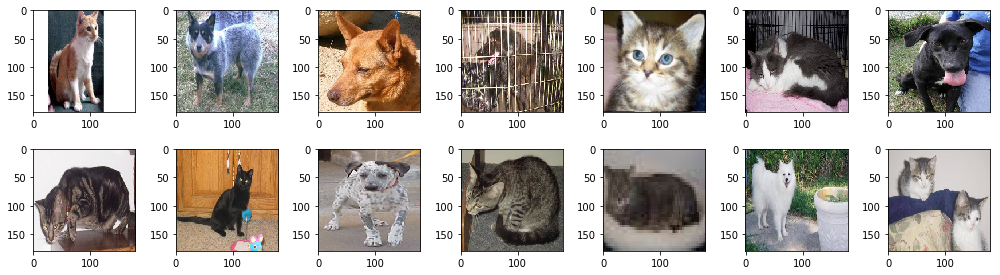

In [23]:
plt.figure(figsize=(14, 4))
for i in range(0, 14):
    plt.subplot(2, 7, i+1)
    for X_batch, Y_batch in o_train_gen:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [103]:
orig_model_1 = Model1()
orig_model_1.fit_gen(o_train_gen, o_valid_gen, epochs=EPOCH)

  0%|          | 0/266 [00:00<?, ?it/s]

-----------------------------------------------------------------
Epochs: 20	| Iterations: 266	| Batch: 64
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1: (204.47182 s) 	 loss - Tr[0.82710] Va[0.65781] 	 acc - Tr[59.81%] Va[56.28%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2: (204.23360 s) 	 loss - Tr[0.64947] Va[0.62445] 	 acc - Tr[58.74%] Va[61.46%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3: (205.00945 s) 	 loss - Tr[0.63912] Va[0.67664] 	 acc - Tr[59.85%] Va[58.67%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4: (204.84899 s) 	 loss - Tr[0.63080] Va[0.62177] 	 acc - Tr[61.10%] Va[63.86%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 5: (204.84578 s) 	 loss - Tr[0.62720] Va[0.61731] 	 acc - Tr[62.79%] Va[63.90%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 6: (203.41755 s) 	 loss - Tr[0.59688] Va[0.57329] 	 acc - Tr[67.54%] Va[71.09%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 7: (203.57316 s) 	 loss - Tr[0.57025] Va[0.56947] 	 acc - Tr[72.03%] Va[71.19%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 8: (204.11119 s) 	 loss - Tr[0.54452] Va[0.56911] 	 acc - Tr[74.58%] Va[70.46%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 9: (204.42713 s) 	 loss - Tr[0.53161] Va[0.56294] 	 acc - Tr[75.71%] Va[73.55%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 10: (203.94135 s) 	 loss - Tr[0.51557] Va[0.51467] 	 acc - Tr[77.95%] Va[76.56%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 11: (204.19894 s) 	 loss - Tr[0.48933] Va[0.48438] 	 acc - Tr[79.78%] Va[79.71%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 12: (203.98347 s) 	 loss - Tr[0.46290] Va[0.48069] 	 acc - Tr[81.74%] Va[79.71%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 13: (203.20551 s) 	 loss - Tr[0.45153] Va[0.46731] 	 acc - Tr[82.48%] Va[80.11%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 14: (202.83306 s) 	 loss - Tr[0.44065] Va[0.48201] 	 acc - Tr[82.85%] Va[78.52%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 15: (204.40068 s) 	 loss - Tr[0.41581] Va[0.43003] 	 acc - Tr[83.41%] Va[80.93%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 16: (204.44693 s) 	 loss - Tr[0.40032] Va[0.43487] 	 acc - Tr[83.82%] Va[80.63%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 17: (204.43174 s) 	 loss - Tr[0.37677] Va[0.43607] 	 acc - Tr[84.95%] Va[80.37%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 18: (204.13238 s) 	 loss - Tr[0.36267] Va[0.39680] 	 acc - Tr[85.89%] Va[83.24%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 19: (204.55985 s) 	 loss - Tr[0.34641] Va[0.37970] 	 acc - Tr[86.30%] Va[84.06%]
-----------------------------------------------------------------


Epoch: 20: 100%|██████████| 266/266 [02:56<00:00,  1.51it/s, acc=88.90%, loss=0.30025]


Epoch 20: (203.83758 s) 	 loss - Tr[0.30025] Va[0.40356] 	 acc - Tr[88.90%] Va[82.90%]
-----------------------------------------------------------------
Finished in: 4082.9197 s


In [104]:
print_test('Original model', orig_model_1)

Original model: loss - 0.4017	 Acc - 82.45%


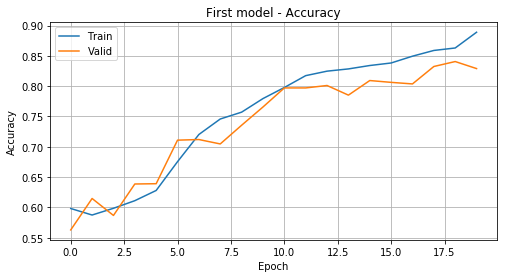

In [105]:
plot_curves(f'First model - Accuracy', [orig_model_1.history['acc_train'], orig_model_1.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


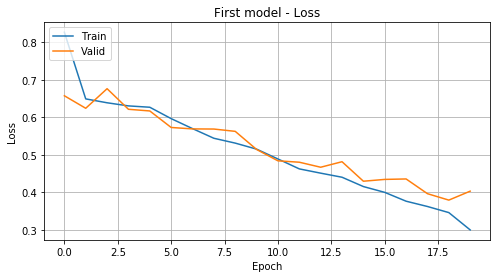

In [106]:
plot_curves(f'First model - Loss', [orig_model_1.history['loss_train'], orig_model_1.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [107]:
orig_predicted_proba = orig_model_1.predict_proba(test_data, batch_size = 1024)

In [108]:
df = predicted_to_df_and_to_file(orig_predicted_proba, 'orig_predicted')
df.head()

,id,label
0,1,0.694808
1,2,0.990000
2,3,0.131629
3,4,0.990000
4,5,0.131629


# dat augmentation

In [49]:
aug_data_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

aug_train_gen = aug_data_gen.flow_from_directory(f'{prepared_path}/train/', class_mode='binary', batch_size=BATCH_SIZE, target_size=IMG_SIZE)


Found 17000 images belonging to 2 classes.


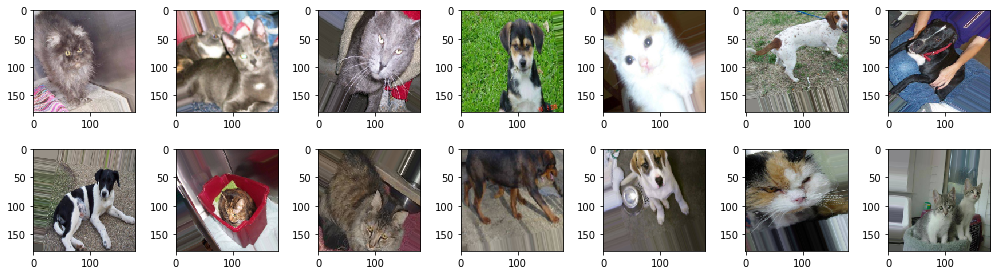

In [50]:
plt.figure(figsize=(14, 4))
for i in range(0, 14):
    plt.subplot(2, 7, i+1)
    X_batch, Y_batch = aug_train_gen.__getitem__(i)
    image = X_batch[0]
    plt.imshow(image)
    
plt.tight_layout()
plt.show()

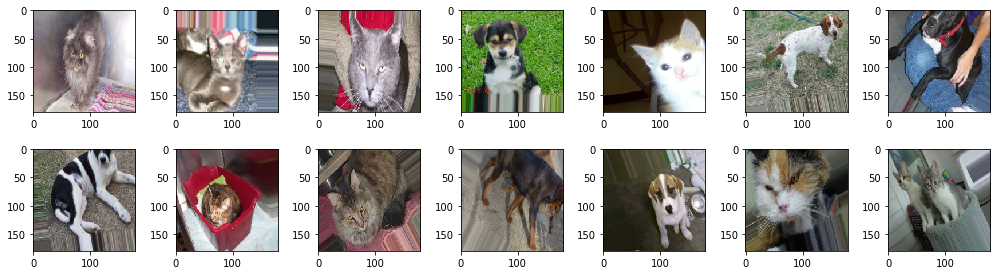

In [51]:
plt.figure(figsize=(14, 4))
for i in range(0, 14):
    plt.subplot(2, 7, i+1)
    X_batch, Y_batch = aug_train_gen.__getitem__(i)
    image = X_batch[0]
    plt.imshow(image)
    
plt.tight_layout()
plt.show()

In [56]:
aug_model_1 = Model1()
aug_model_1.fit_gen(aug_train_gen, o_valid_gen, epochs=EPOCH)

  0%|          | 0/266 [00:00<?, ?it/s]

-----------------------------------------------------------------
Epochs: 20	| Iterations: 266	| Batch: 64
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1: (320.91709 s) 	 loss - Tr[0.87610] Va[0.68335] 	 acc - Tr[56.44%] Va[51.30%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2: (316.44168 s) 	 loss - Tr[0.67947] Va[0.66988] 	 acc - Tr[53.71%] Va[54.67%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3: (317.86240 s) 	 loss - Tr[0.66815] Va[0.66592] 	 acc - Tr[56.04%] Va[55.74%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4: (320.01763 s) 	 loss - Tr[0.66615] Va[0.66085] 	 acc - Tr[56.58%] Va[56.59%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 5: (320.35797 s) 	 loss - Tr[0.65885] Va[0.67010] 	 acc - Tr[57.36%] Va[54.34%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 6: (317.20713 s) 	 loss - Tr[0.65144] Va[0.66479] 	 acc - Tr[58.84%] Va[55.74%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 7: (316.69062 s) 	 loss - Tr[0.64843] Va[0.64932] 	 acc - Tr[59.53%] Va[58.69%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 8: (320.39642 s) 	 loss - Tr[0.64168] Va[0.63731] 	 acc - Tr[60.27%] Va[60.28%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 9: (317.25159 s) 	 loss - Tr[0.63677] Va[0.60999] 	 acc - Tr[61.12%] Va[64.73%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 10: (318.25654 s) 	 loss - Tr[0.63046] Va[0.62514] 	 acc - Tr[62.70%] Va[63.15%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 11: (317.73641 s) 	 loss - Tr[0.62215] Va[0.61591] 	 acc - Tr[64.73%] Va[65.79%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 12: (318.68155 s) 	 loss - Tr[0.60588] Va[0.57431] 	 acc - Tr[67.69%] Va[72.09%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 13: (319.36760 s) 	 loss - Tr[0.59646] Va[0.57408] 	 acc - Tr[69.27%] Va[70.09%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 14: (318.43236 s) 	 loss - Tr[0.57805] Va[0.56132] 	 acc - Tr[70.70%] Va[72.63%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 15: (319.60106 s) 	 loss - Tr[0.57737] Va[0.55318] 	 acc - Tr[70.94%] Va[73.41%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 16: (321.98901 s) 	 loss - Tr[0.57364] Va[0.54290] 	 acc - Tr[71.10%] Va[74.87%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 17: (320.11581 s) 	 loss - Tr[0.56508] Va[0.55103] 	 acc - Tr[72.19%] Va[73.65%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 18: (319.76980 s) 	 loss - Tr[0.55832] Va[0.52692] 	 acc - Tr[72.02%] Va[75.99%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 19: (318.03733 s) 	 loss - Tr[0.55664] Va[0.54371] 	 acc - Tr[72.69%] Va[76.16%]
-----------------------------------------------------------------


Epoch: 20: 100%|██████████| 266/266 [04:53<00:00,  1.10s/it, acc=73.81%, loss=0.54190]


Epoch 20: (320.72996 s) 	 loss - Tr[0.54190] Va[0.50010] 	 acc - Tr[73.81%] Va[77.23%]
-----------------------------------------------------------------
Finished in: 6379.8685 s


In [58]:
aug_model_1.fit_gen(aug_train_gen, o_valid_gen, epochs=5)

  0%|          | 0/266 [00:00<?, ?it/s]

-----------------------------------------------------------------
Epochs: 5	| Iterations: 266	| Batch: 64
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1: (320.68504 s) 	 loss - Tr[0.53746] Va[0.50409] 	 acc - Tr[74.72%] Va[78.15%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2: (318.23245 s) 	 loss - Tr[0.53288] Va[0.49204] 	 acc - Tr[74.63%] Va[78.43%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3: (317.32928 s) 	 loss - Tr[0.52247] Va[0.50848] 	 acc - Tr[75.54%] Va[78.21%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4: (321.48382 s) 	 loss - Tr[0.51776] Va[0.50066] 	 acc - Tr[75.87%] Va[78.04%]
-----------------------------------------------------------------


Epoch: 5: 100%|██████████| 266/266 [04:51<00:00,  1.10s/it, acc=75.11%, loss=0.52703]


Epoch 5: (319.84679 s) 	 loss - Tr[0.52703] Va[0.48285] 	 acc - Tr[75.11%] Va[78.76%]
-----------------------------------------------------------------
Finished in: 1597.5807 s


In [59]:
aug_model_1.fit_gen(aug_train_gen, o_valid_gen, epochs=5)

  0%|          | 0/266 [00:00<?, ?it/s]

-----------------------------------------------------------------
Epochs: 5	| Iterations: 266	| Batch: 64
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1: (320.51805 s) 	 loss - Tr[0.51879] Va[0.47187] 	 acc - Tr[75.42%] Va[79.95%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2: (320.02453 s) 	 loss - Tr[0.50451] Va[0.47056] 	 acc - Tr[76.82%] Va[79.86%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3: (319.76021 s) 	 loss - Tr[0.50397] Va[0.45783] 	 acc - Tr[77.03%] Va[80.37%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4: (319.43688 s) 	 loss - Tr[0.48236] Va[0.44702] 	 acc - Tr[78.01%] Va[81.33%]
-----------------------------------------------------------------


Epoch: 5: 100%|██████████| 266/266 [04:51<00:00,  1.10s/it, acc=78.24%, loss=0.47696]


Epoch 5: (319.33675 s) 	 loss - Tr[0.47696] Va[0.45198] 	 acc - Tr[78.24%] Va[81.28%]
-----------------------------------------------------------------
Finished in: 1599.0788 s


In [60]:
aug_model_1.fit_gen(aug_train_gen, o_valid_gen, epochs=5)

  0%|          | 0/266 [00:00<?, ?it/s]

-----------------------------------------------------------------
Epochs: 5	| Iterations: 266	| Batch: 64
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1: (317.93822 s) 	 loss - Tr[0.47359] Va[0.41138] 	 acc - Tr[78.78%] Va[82.87%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2: (320.55934 s) 	 loss - Tr[0.47223] Va[0.45032] 	 acc - Tr[78.44%] Va[82.18%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3: (318.49044 s) 	 loss - Tr[0.46661] Va[0.42159] 	 acc - Tr[78.68%] Va[82.37%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4: (319.10712 s) 	 loss - Tr[0.45882] Va[0.43822] 	 acc - Tr[79.12%] Va[82.69%]
-----------------------------------------------------------------


Epoch: 5: 100%|██████████| 266/266 [04:51<00:00,  1.09s/it, acc=79.98%, loss=0.45178]


Epoch 5: (318.57998 s) 	 loss - Tr[0.45178] Va[0.38705] 	 acc - Tr[79.98%] Va[83.73%]
-----------------------------------------------------------------
Finished in: 1594.6772 s


In [61]:
aug_model_1.fit_gen(aug_train_gen, o_valid_gen, epochs=5)

  0%|          | 0/266 [00:00<?, ?it/s]

-----------------------------------------------------------------
Epochs: 5	| Iterations: 266	| Batch: 64
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1: (320.38993 s) 	 loss - Tr[0.45202] Va[0.41757] 	 acc - Tr[79.95%] Va[82.53%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2: (319.80272 s) 	 loss - Tr[0.42640] Va[0.38828] 	 acc - Tr[81.20%] Va[85.36%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3: (323.19405 s) 	 loss - Tr[0.41994] Va[0.38873] 	 acc - Tr[81.56%] Va[84.57%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4: (318.97730 s) 	 loss - Tr[0.42293] Va[0.35863] 	 acc - Tr[81.41%] Va[85.24%]
-----------------------------------------------------------------


Epoch: 5: 100%|██████████| 266/266 [04:52<00:00,  1.10s/it, acc=82.07%, loss=0.40843]


Epoch 5: (319.19824 s) 	 loss - Tr[0.40843] Va[0.37644] 	 acc - Tr[82.07%] Va[84.41%]
-----------------------------------------------------------------
Finished in: 1601.5642 s


In [74]:
print_test('Aug model', aug_model_1)

Aug model: loss - 0.3793	 Acc - 84.72%


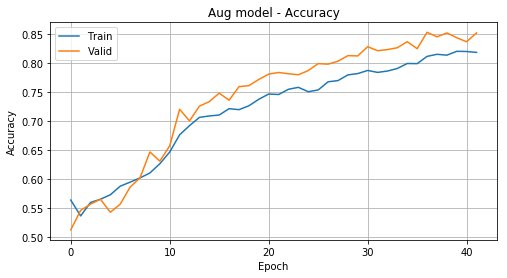

In [76]:
plot_curves(f'Aug model - Accuracy', [aug_model_1.history['acc_train'], aug_model_1.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


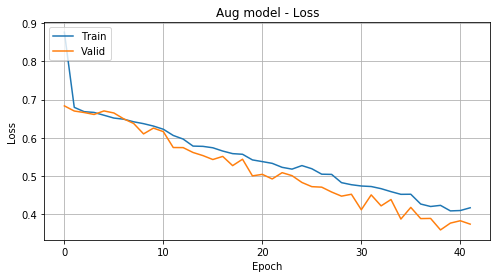

In [77]:
plot_curves(f'Aug model - Loss', [aug_model_1.history['loss_train'], aug_model_1.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [78]:
aug_predicted_proba = aug_model_1.predict_proba(test_data, batch_size = 1024)

In [81]:
df = predicted_to_df_and_to_file(aug_predicted_proba, 'aug_predicted')
df.head()

,id,label
0,1,0.849279
1,2,0.911332
2,3,0.126351
3,4,0.988025
4,5,0.126351


# Transfer Learning

In [82]:
import tensorflow.keras as keras

In [83]:
def get_vgg16_model():
    vgg16 = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, CHANNELS))
    vgg16.trainable = True
    trainable = False
    for layer in vgg16.layers:
        if layer.name == 'block5_conv1':
            trainable = True
        layer.trainable = trainable

    model = keras.Sequential()

    model.add(vgg16)
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=1e-5), 
                  metrics=['accuracy'])
    return model

In [84]:
tr_l_model = get_vgg16_model()

In [85]:
tr_l_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1638528   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [86]:
tr_l_model.fit_generator(
    o_train_gen,
    steps_per_epoch=len(o_train_gen),
    epochs=TR_LAERN_EPOCH,
    validation_data=o_valid_gen,
    validation_steps=len(o_valid_gen)
)

Epoch 1/10
266/266 [==============================] - 136s 512ms/step - loss: 0.4648 - acc: 0.7640 - val_loss: 0.1998 - val_acc: 0.9172
Epoch 2/10
266/266 [==============================] - 135s 506ms/step - loss: 0.2183 - acc: 0.9156 - val_loss: 0.1511 - val_acc: 0.9400
Epoch 3/10
266/266 [==============================] - 136s 511ms/step - loss: 0.1592 - acc: 0.9419 - val_loss: 0.1352 - val_acc: 0.9435
Epoch 4/10
266/266 [==============================] - 136s 510ms/step - loss: 0.1333 - acc: 0.9516 - val_loss: 0.1391 - val_acc: 0.9445
Epoch 5/10
266/266 [==============================] - 135s 507ms/step - loss: 0.1092 - acc: 0.9599 - val_loss: 0.1400 - val_acc: 0.9433
Epoch 6/10
266/266 [==============================] - 135s 508ms/step - loss: 0.0940 - acc: 0.9658 - val_loss: 0.1461 - val_acc: 0.9390
Epoch 7/10
266/266 [==============================] - 136s 509ms/step - loss: 0.0755 - acc: 0.9735 - val_loss: 0.1233 - val_acc: 0.9532
Epoch 8/10
266/266 [============================

In [87]:
tr_l_loss, tr_l_acc = tr_l_model.evaluate_generator(o_test_gen, steps=len(o_test_gen))
tr_l_loss, tr_l_acc

(0.1180751146748662, 0.9575)

In [88]:
print(f'Transfer Learning vgg16: loss - {tr_l_loss:.4f}\t Acc - {tr_l_acc:.02%}')

Transfer Learning vgg16: loss - 0.1181	 Acc - 95.75%


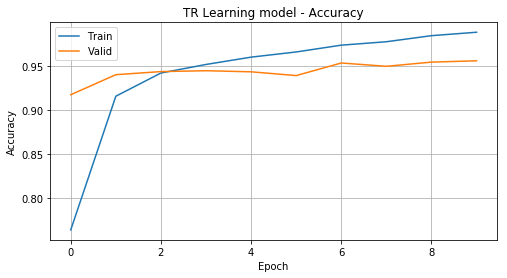

In [89]:
plot_curves(f'TR Learning model - Accuracy', [tr_l_model.history.history['acc'], tr_l_model.history.history['val_acc']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


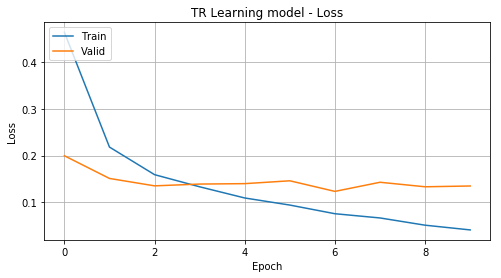

In [90]:
plot_curves(f'TR Learning model - Loss', [tr_l_model.history.history['loss'], tr_l_model.history.history['val_loss']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [91]:
tr_l_predicted_proba = tr_l_model.predict_proba(test_data)

In [92]:
df = predicted_to_df_and_to_file(tr_l_predicted_proba, 'tr_l_predicted')
df.head()

,id,label
0,1,0.99
1,2,0.99
2,3,0.01
3,4,0.99
4,5,0.01


In [93]:
tr_l_model_aug = get_vgg16_model()
tr_l_model_aug.fit_generator(
    aug_train_gen,
    steps_per_epoch=len(aug_train_gen),
    epochs=TR_LAERN_EPOCH,
    validation_data=o_valid_gen,
    validation_steps=len(o_valid_gen)
)

tr_l_loss_aug, tr_l_acc_aug = tr_l_model_aug.evaluate_generator(o_test_gen, steps=len(o_test_gen))
tr_l_loss_aug, tr_l_acc_aug

Epoch 1/10
266/266 [==============================] - 247s 929ms/step - loss: 0.5791 - acc: 0.6799 - val_loss: 0.2443 - val_acc: 0.8950
Epoch 2/10
266/266 [==============================] - 239s 899ms/step - loss: 0.3301 - acc: 0.8618 - val_loss: 0.1638 - val_acc: 0.9360
Epoch 3/10
266/266 [==============================] - 239s 898ms/step - loss: 0.2627 - acc: 0.8954 - val_loss: 0.1468 - val_acc: 0.9430
Epoch 4/10
266/266 [==============================] - 238s 893ms/step - loss: 0.2243 - acc: 0.9108 - val_loss: 0.1283 - val_acc: 0.9505
Epoch 5/10
266/266 [==============================] - 240s 901ms/step - loss: 0.2056 - acc: 0.9215 - val_loss: 0.1232 - val_acc: 0.9485
Epoch 6/10
266/266 [==============================] - 239s 898ms/step - loss: 0.1903 - acc: 0.9265 - val_loss: 0.1240 - val_acc: 0.9498
Epoch 7/10
266/266 [==============================] - 239s 897ms/step - loss: 0.1794 - acc: 0.9319 - val_loss: 0.1206 - val_acc: 0.9517
Epoch 8/10
266/266 [============================

(0.11883099470287561, 0.9515)

In [94]:
print(f'Transfer Learning vgg16: loss - {tr_l_loss_aug:.4f}\t Acc - {tr_l_acc_aug:.02%}')

Transfer Learning vgg16: loss - 0.1188	 Acc - 95.15%


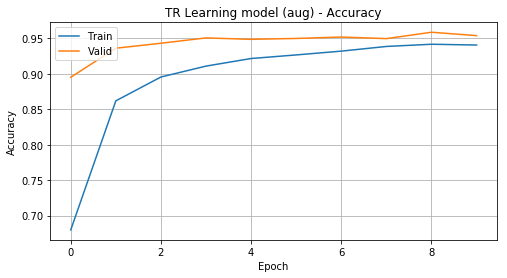

In [96]:
plot_curves(f'TR Learning model (aug) - Accuracy', [tr_l_model_aug.history.history['acc'], tr_l_model_aug.history.history['val_acc']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


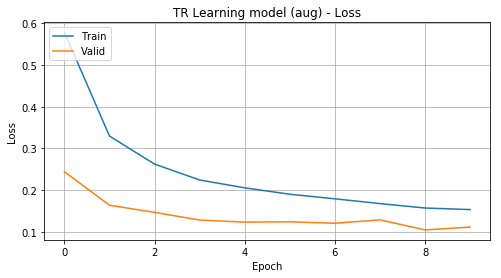

In [95]:
plot_curves(f'TR Learning model (aug) - Loss', [tr_l_model_aug.history.history['loss'], tr_l_model_aug.history.history['val_loss']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [97]:
tr_l_predicted_proba_aug = tr_l_model_aug.predict_proba(test_data)

In [98]:
df = predicted_to_df_and_to_file(tr_l_predicted_proba_aug, 'tr_l_predicted_aug')
df.head()

,id,label
0,1,0.990000
1,2,0.990000
2,3,0.057069
3,4,0.990000
4,5,0.010000


In [109]:
_, aug_test_acc = aug_model_1.evaluate_gen(o_test_gen)

In [110]:
_, orig_test_acc = orig_model_1.evaluate_gen(o_test_gen)

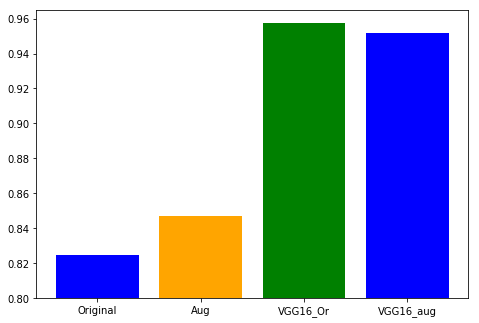

In [113]:
labels = ['Original', 'Aug', 'VGG16_Or', 'VGG16_aug']
test_acc = [orig_test_acc, aug_test_acc, tr_l_acc, tr_l_acc_aug]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,test_acc, color=['Blue', 'Orange', 'Green'])
plt.ylim(0.8, 0.965)
plt.show()